In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        # tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=2048)]) # set hard memory limit
        tf.config.experimental.set_memory_growth(gpus[0], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
print("TensorFlow version:", tf.__version__)

3 Physical GPUs, 1 Logical GPU
TensorFlow version: 2.7.0


2022-12-12 12:32:31.272197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 12:32:32.364504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47056 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [2]:
import configparser
config = configparser.ConfigParser()
config.read('_system.ini')
results_dir = config['system_info']['alternate_location']

from pathlib import Path
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt

from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()
from tensorflow.keras.optimizers import Adam

import MD_AE_tools.models.models_no_bias as mdl_nobias
import MD_AE_tools.mode_decomposition as md
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder

In [3]:
parent_folder = Path(results_dir,'experiment_nonlinear')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder

0808_2mode1-2894758  0808_2mode5-2894762  0808_2mode9-2894766
0808_2mode2-2894759  0808_2mode6-2894763  0808_2mode10-2894767
0808_2mode3-2894760  0808_2mode7-2894764
0808_2mode4-2894761  0808_2mode8-2894765


In [4]:
folder = '0808_2mode5-2894762'
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
mdl_config = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.3952428


Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
MSE reconstructed with 2 modes is:  1.4777343273162842
Calculating POD ...
User has selected classic POD
POD done.


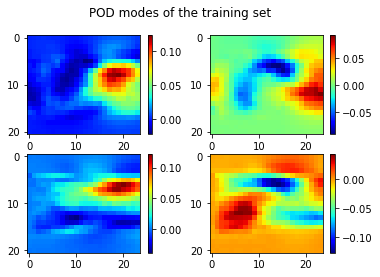

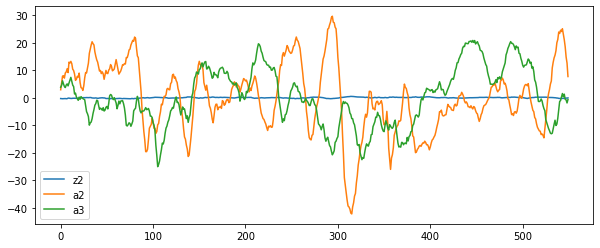

In [5]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
pod_test = md.POD(X_test,method='classic')
A_test = pod_test.get_time_coefficient
Q_POD_test, lam_data_test = pod_test.get_modes
plt.figure(figsize=(10,4))
# plt.plot(A[:,0],label='a1')
plt.plot(latent_test[:,1],label='z2')
plt.plot(A_test[:,1],label='a2')
plt.plot(A_test[:,2],label='a3')
plt.legend()
# plt.xlim([0,100])

plt.show()

# Get model

In [6]:
mdl = mdl_nobias.MD_Autoencoder(Nx=mdl_config.Nx,Nu=mdl_config.Nu,
                            features_layers=mdl_config.features_layers,
                            latent_dim=mdl_config.latent_dim,
                            filter_window=mdl_config.filter_window,
                            act_fct=mdl_config.act_fct,
                            batch_norm=mdl_config.BATCH_NORM,
                            drop_rate=mdl_config.drop_rate,
                            lmb=mdl_config.lmb,
                            resize_meth=mdl_config.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=mdl_config.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ===============================================
decoders = mdl.get_decoders()

2022-12-12 12:32:43.021968: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


51/51 [==============================] - 0s 8ms/step - loss: 1.4174


# Gradient tape

In [101]:
@tf.function
def get_gradient_z(z,decoder):
    with tf.GradientTape() as tape:
        tape.watch(z)
        pred = decoder(z,training=False)
    dy_dz = tape.jacobian(pred,z)
    print(dy_dz.shape)
    return dy_dz

In [95]:
def one_step_integrate(t, dx_dt, t0, x0, dt):
    x = [0]
    for i in range(0,len(t)-1):
        x.append(x[i] + dt*dx_dt[i])
    idx_0 = np.squeeze(np.argwhere(t==t0))
    x = x - x[idx_0] + x0
    return x 

## Numerical gradient and integrate

In [116]:
z = tf.convert_to_tensor(np.array([[0.1,0.2,0.3]]).T.astype('float32'))
steps = z.shape[0]

In [117]:
dy_dz = []
for i in range(mdl_config.latent_dim):
    dy_dz_i = []
    for t in range(steps):
        gradients = get_gradient_z(z,decoders[i]) ## get gradients
        dyt_dzt = gradients[t,:,:,:,t,0] ## keep only the relavent gradient
        dy_dz_i.append(dyt_dzt) 
    
    dy_dz.append(dy_dz_i)

dy_dz = np.array(dy_dz)

In [118]:
dy_dz_temp = einsum('k t y z u -> k y z t u', dy_dz)
for i in range(mdl_config.latent_dim):
    dy_dz_reshape = np.vstack((dy_dz_temp[i,:,:,:,0], dy_dz_temp[i,:,:,:,1]))
    dy_dz_reshape = np.reshape(dy_dz_reshape,(-1, steps))

In [120]:
dy_dz_reshape.shape

(1008, 3)